In [1]:
# Parameters
run_dir = "/Users/daws/ADMF-PC/config/bollinger/results/20250627_094515"
config_name = "bollinger"
symbols = ["SPY"]
timeframe = "5m"
min_strategies_to_analyze = 20
sharpe_threshold = 1.0
correlation_threshold = 0.7
top_n_strategies = 10
ensemble_size = 5
calculate_all_performance = True
performance_limit = 100


# Trade & Risk Analysis Notebook\n\nAnalyzes trading performance through orders, fills, and position events.

In [2]:
import pandas as pd
import numpy as np
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8-darkgrid')

## 1. Load Trace Data

In [3]:
# Set the results directory
results_dir = Path('.')
traces_dir = results_dir / 'traces'

# Load trace files
traces = {}

# Strategy signals
signals_path = list(traces_dir.rglob('signals/*/*.parquet'))
if signals_path:
    traces['signals'] = pd.read_parquet(signals_path[0])
    print(f"Loaded signals: {len(traces['signals'])} records")

# Portfolio orders
orders_path = traces_dir / 'portfolio' / 'orders' / 'portfolio_orders.parquet'
if orders_path.exists():
    traces['orders'] = pd.read_parquet(orders_path)
    print(f"Loaded orders: {len(traces['orders'])} records")

# Execution fills
fills_path = traces_dir / 'execution' / 'fills' / 'execution_fills.parquet'
if fills_path.exists():
    traces['fills'] = pd.read_parquet(fills_path)
    print(f"Loaded fills: {len(traces['fills'])} records")

# Position events
pos_open_path = traces_dir / 'portfolio' / 'positions_open' / 'position_open.parquet'
if pos_open_path.exists():
    traces['position_open'] = pd.read_parquet(pos_open_path)
    print(f"Loaded position opens: {len(traces['position_open'])} records")

pos_close_path = traces_dir / 'portfolio' / 'positions_close' / 'position_close.parquet'
if pos_close_path.exists():
    traces['position_close'] = pd.read_parquet(pos_close_path)
    print(f"Loaded position closes: {len(traces['position_close'])} records")

Loaded signals: 2762 records
Loaded orders: 547 records
Loaded fills: 547 records
Loaded position opens: 1 records
Loaded position closes: 1 records


## 2. Parse Metadata

In [4]:
# Parse JSON metadata for position events
for event_type in ['position_open', 'position_close']:
    if event_type in traces:
        df = traces[event_type]
        if 'metadata' in df.columns:
            # Parse metadata
            metadata_parsed = df['metadata'].apply(lambda x: json.loads(x) if x else {})
            metadata_df = pd.DataFrame(list(metadata_parsed))
            
            # Add parsed columns to original dataframe
            for col in metadata_df.columns:
                if col not in df.columns:
                    df[col] = metadata_df[col]
            
            print(f"Parsed {event_type} metadata: {list(metadata_df.columns)}")

Parsed position_open metadata: ['symbol', 'strategy_id', 'quantity', 'entry_price', 'exit_price', 'exit_type', 'exit_reason', 'metadata']
Parsed position_close metadata: ['symbol', 'strategy_id', 'quantity', 'entry_price', 'exit_price', 'exit_type', 'exit_reason', 'metadata']


## 3. Analyze Risk Exits

In [5]:
if 'position_close' in traces:
    pos_close = traces['position_close']
    print("=== Risk Management Exit Analysis ===")
    print(f"Total positions closed: {len(pos_close)}")
    
    if 'exit_type' in pos_close.columns:
        exit_counts = pos_close['exit_type'].value_counts()
        print("\nExit types:")
        for exit_type, count in exit_counts.items():
            pct = count/len(pos_close)*100
            print(f"  {exit_type}: {count} ({pct:.1f}%)")
    
    if 'exit_reason' in pos_close.columns:
        print("\nSample exit reasons:")
        for i, row in pos_close.head(5).iterrows():
            exit_type = row.get('exit_type', 'unknown')
            exit_reason = row.get('exit_reason', 'unknown')
            print(f"  {exit_type}: {exit_reason}")

=== Risk Management Exit Analysis ===
Total positions closed: 1

Exit types:

Sample exit reasons:
  None: None


## 4. Signal Persistence Analysis

In [6]:
# Check if signals persist after risk exits
if 'signals' in traces and 'position_close' in traces:
    signals_df = traces['signals']
    pos_close = traces['position_close']
    
    print("=== Signal Persistence After Risk Exits ===")
    
    # Find risk exits
    if 'exit_type' in pos_close.columns:
        risk_exits = pos_close[pos_close['exit_type'].isin(['stop_loss', 'trailing_stop'])]
        
        if len(risk_exits) > 0:
            print(f"Found {len(risk_exits)} risk exits")
            
            # Check first few risk exits
            for idx, exit_row in risk_exits.head(3).iterrows():
                exit_bar = exit_row['idx']
                
                # Get signals around exit
                next_signals = signals_df[
                    (signals_df['idx'] >= exit_bar) & 
                    (signals_df['idx'] <= exit_bar + 5)
                ]
                
                if len(next_signals) > 0:
                    print(f"\nExit at bar {exit_bar} ({exit_row['exit_type']}):")
                    for _, sig in next_signals.iterrows():
                        print(f"  Bar {sig['idx']}: signal = {sig['val']}")

=== Signal Persistence After Risk Exits ===


## 5. Order Flow Analysis

=== Order Flow Analysis ===
Total orders: 547

Time between orders:
  Mean: 30.3 bars
  Median: 20.0 bars
  Min: 1 bars

Immediate re-entries (≤1 bar): 1


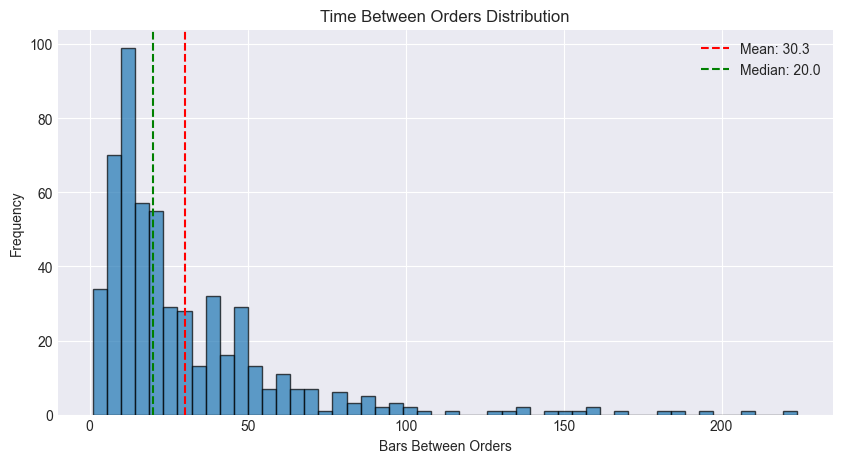

In [7]:
if 'orders' in traces:
    orders_df = traces['orders']
    print("=== Order Flow Analysis ===")
    print(f"Total orders: {len(orders_df)}")
    
    if len(orders_df) > 1:
        # Calculate time between orders
        order_gaps = orders_df['idx'].diff().dropna()
        
        print(f"\nTime between orders:")
        print(f"  Mean: {order_gaps.mean():.1f} bars")
        print(f"  Median: {order_gaps.median():.1f} bars")
        print(f"  Min: {order_gaps.min():.0f} bars")
        
        # Check for immediate re-entries
        immediate = (order_gaps <= 1).sum()
        print(f"\nImmediate re-entries (≤1 bar): {immediate}")
        
        # Plot distribution
        plt.figure(figsize=(10, 5))
        plt.hist(order_gaps, bins=50, alpha=0.7, edgecolor='black')
        plt.axvline(order_gaps.mean(), color='red', linestyle='--', label=f'Mean: {order_gaps.mean():.1f}')
        plt.axvline(order_gaps.median(), color='green', linestyle='--', label=f'Median: {order_gaps.median():.1f}')
        plt.xlabel('Bars Between Orders')
        plt.ylabel('Frequency')
        plt.title('Time Between Orders Distribution')
        plt.legend()
        plt.show()

## 6. Trade Performance Summary

In [8]:
print("=== SUMMARY ===")

# Data summary
print("\nData loaded:")
for key, df in traces.items():
    print(f"  {key}: {len(df)} records")

# Key metrics
if 'orders' in traces and 'fills' in traces:
    fill_rate = len(traces['fills']) / len(traces['orders']) * 100
    print(f"\nOrder fill rate: {fill_rate:.1f}%")

if 'position_close' in traces and 'exit_type' in traces['position_close'].columns:
    pos_close = traces['position_close']
    risk_exits = pos_close['exit_type'].isin(['stop_loss', 'take_profit', 'trailing_stop']).sum()
    risk_pct = risk_exits / len(pos_close) * 100 if len(pos_close) > 0 else 0
    print(f"Risk management exits: {risk_exits} ({risk_pct:.1f}%)")

print("\n=== RECOMMENDATIONS ===")
print("1. Implement cooldown period after risk exits")
print("2. Review stop loss parameters if many immediate re-entries")
print("3. Consider signal filtering after stop losses")

=== SUMMARY ===

Data loaded:
  signals: 2762 records
  orders: 547 records
  fills: 547 records
  position_open: 1 records
  position_close: 1 records

Order fill rate: 100.0%
Risk management exits: 0 (0.0%)

=== RECOMMENDATIONS ===
1. Implement cooldown period after risk exits
2. Review stop loss parameters if many immediate re-entries
3. Consider signal filtering after stop losses
